In [37]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import folium
from requests.structures import CaseInsensitiveDict
import os
import holoviews as hv
import geopandas as gpd
from geopy.distance import geodesic
from folium.plugins import MarkerCluster, HeatMap

# Import API key
from api_keys import geoapify_key

# Load CSV
tesla_ev_wa_df = pd.read_csv("resources/tesla_ev_wa.csv")
coffee_info_df = pd.read_csv("resources/coffee_info_tesla_ev.csv")


In [38]:
coffee_info_df.head()

,Address,City,State,ZIP,Restaurant Name,Latitude,Longitude,Formatted Address
0,416 Wishkah Street,Aberdeen,WA,98520,Dutch Bros. Coffee,46.977415,-123.808426,"Dutch Bros. Coffee, East Wishkah Street, Aberd..."
1,416 Wishkah Street,Aberdeen,WA,98520,Starbucks,46.977603,-123.802957,"Starbucks, 1202 East Wishkah Street, Aberdeen,..."
2,9384 Old Highway 99 North,Burlington,WA,98233,The Coffee Barn,48.507100,-122.337733,"The Coffee Barn, 9552 Old Highway 99 North Roa..."
3,9384 Old Highway 99 North,Burlington,WA,98233,Foxy Lady Latte,48.506708,-122.337614,"Foxy Lady Latte, 9566 Old Highway 99 North Roa..."
4,1200 Lum Rd,Centralia,WA,98531,Starbucks,46.728547,-122.981222,"Starbucks, Harrison Avenue, Centralia, WA 9853..."


In [39]:
tesla_ev_wa_df.head()

,Fuel Type Code,Station Name,Street Address,City,State,ZIP,Groups With Access Code,Access Days Time,EV Network,Facility Type,EV Pricing,Geocode Status,Latitude,Longitude,Status Code
0,ELEC,"Aberdeen, WA - Tesla Supercharger",416 Wishkah Street,Aberdeen,WA,98520,Public,24 hours daily,Tesla,NaN,NaN,GPS,46.976679,-123.813485,E
1,ELEC,Angel of the Winds Casino - Tesla Supercharger,3438 Stoluckquamish Lane,Arlington,WA,98223,Public,24 hours daily,Tesla,OTHER_ENTERTAINMENT,NaN,GPS,48.212441,-122.183491,E
2,ELEC,Fairfield Inn & Suites Burlington - Tesla Supe...,9384 Old Highway 99 North,Burlington,WA,98233,Public,24 hours daily,Tesla,NaN,NaN,200-8,48.509743,-122.338681,E
3,ELEC,Centralia Outlets - Tesla Supercharger,1200 Lum Rd,Centralia,WA,98531,Public,24 hours daily,Tesla,NaN,NaN,200-9,46.729872,-122.977392,E
4,ELEC,Holiday Inn Express - Tesla Supercharger,1620 Canyon Rd,Ellensburg,WA,98926,Public,24 hours daily,Tesla,NaN,NaN,GPS,46.976918,-120.541620,E



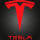
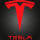
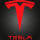
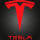
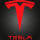
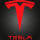
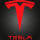
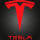
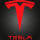
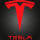
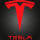
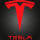
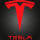
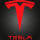
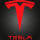
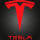
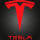
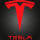
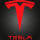
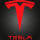
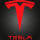
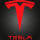
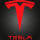
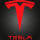
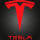
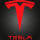
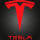
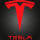
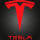
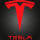
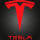
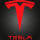
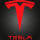
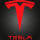
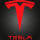
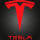
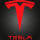
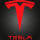
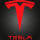
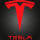
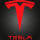
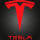
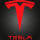
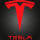
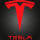
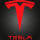
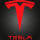
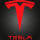
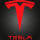
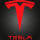
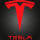
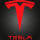
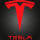
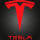
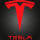
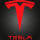
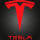
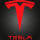
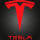
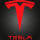
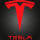
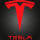
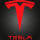
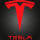
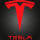
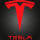
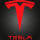
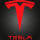
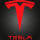
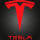
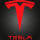
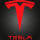
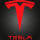
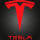
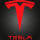
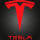
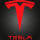
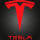
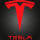
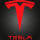
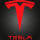
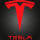
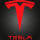
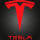
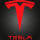
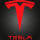
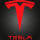
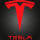
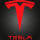
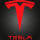
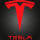
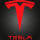
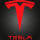
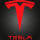
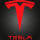
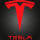
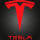
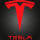
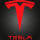
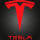
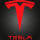
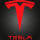
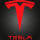
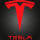
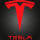
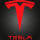
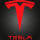
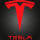
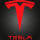
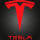
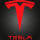
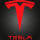
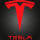
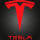
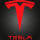
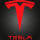
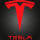
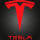
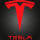
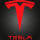
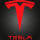
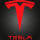
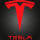
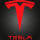
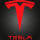
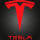
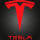
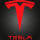
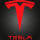
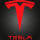
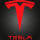
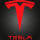
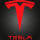
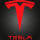
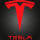
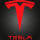
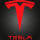
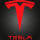
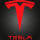
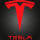
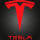
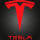
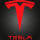
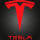
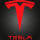
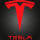
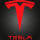
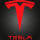
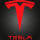
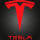
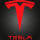
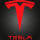
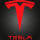
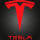
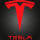
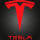
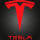
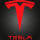
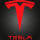
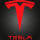
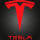
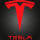
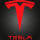
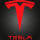
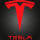
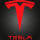
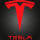
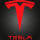
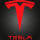
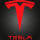
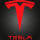
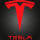
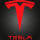

In [40]:
# Create a map centered on Washington State
tesla_coffee_map = folium.Map(location=[47.7511, -120.7401], zoom_start=7)

# Create a feature group for Tesla EV stations
tesla_group = folium.FeatureGroup(name="Tesla EV Stations")
tesla_coffee_map.add_child(tesla_group)

# Create a feature group for Coffee Shops
coffee_group = folium.FeatureGroup(name="Coffee Shops")
tesla_coffee_map.add_child(coffee_group)

# Create lists to store locations for heatmap
coffee_locations = []
tesla_locations = []

# Iterate through each Tesla EV charging station
for _, station in tesla_ev_wa_df.iterrows():
    tesla_location = (station['Latitude'], station['Longitude'])

    # Add Tesla locations to the list
    tesla_locations.append(tesla_location)

    # Construct popup content for Tesla EV charging station
    popup_content_station = f"<b>Name:</b> {station['Station Name']}<br>"
    popup_content_station += f"<b>Street Address:</b> {station['Street Address']}<br>"
    popup_content_station += f"<b>City:</b> {station['City']}<br>"
    popup_content_station += f"<b>EV Network:</b> {station['EV Network']}<br>"
    popup_content_station += f"<b>Facility Type:</b> {station['Facility Type']}<br>"
    
    # Add Tesla locations to the map
    folium.Marker(
        location=tesla_location,
        popup=popup_content_station,
        icon=folium.CustomIcon(
            icon_image='resources/tesla_logo.png',
            icon_size=(30, 30) 
        )
    ).add_to(tesla_group)
    
    # Check if there are nearby coffee shops
    nearby_coffee_shops = coffee_info_df[coffee_info_df['Address'] == station['Street Address']]
    
    if len(nearby_coffee_shops) > 0:
        # If there are nearby coffee shops, construct popup content for each one
        for _, coffee in nearby_coffee_shops.iterrows():
            coffee_location = (coffee['Latitude'], coffee['Longitude'])
            distance = geodesic(coffee_location, tesla_location).miles 
            
            # Add coffee locations to the list
            coffee_locations.append(coffee_location)

            # Construct popup content for the coffee shop
            popup_content_coffee = f"<b>Name:</b> {coffee['Restaurant Name']}<br>"
            popup_content_coffee += f"<b>Distance from EV Station:</b> {distance:.2f} miles<br>"
            popup_content_coffee += f"<b>Address:</b> {coffee['Formatted Address']}<br>" 

            folium.Marker(
                location=coffee_location,
                popup=popup_content_coffee,
                icon=folium.Icon(color='green', icon='coffee', prefix='fa')
            ).add_to(coffee_group)
                  
# Create a HeatMap layer with the coffee locations
heatmap = HeatMap(data=tesla_locations, name='Tesla EV Heatmap', radius=15, blur=10)
tesla_coffee_map.add_child(heatmap)

# Create a MarkerCluster layer for Tesla locations
tesla_cluster = MarkerCluster(name='Tesla EV Cluster').add_to(tesla_coffee_map)
# Iterate through each Tesla location and add marker to the cluster
for location in tesla_locations:
    folium.CircleMarker(location=location, radius=5, fill=True, color='blue', fill_color='blue').add_to(tesla_cluster)

# Add layer control
folium.LayerControl().add_to(tesla_coffee_map)

# Add legend
legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: auto; 
     border: 2px solid #666; border-radius: 5px; background-color: #fff; 
     z-index: 1000; font-size: 14px; padding: 10px;">
     <strong>Map Legend</strong><br>
     &nbsp; Tesla EV &nbsp; <i class="fa fa-car fa-2x" style="color: red"></i><br>
     &nbsp; Coffee &nbsp; <i class="fa fa-coffee fa-2x" style="color: green"></i><br>
     </div>
     '''
tesla_coffee_map.get_root().html.add_child(folium.Element(legend_html))

# Display
tesla_coffee_map

In [41]:
# Save the map as an HTML file
tesla_coffee_map.save("resources/map_tesla_coffee_wa.html")

print("Map saved successfully as 'map_tesla_coffee_wa.html' in the resources folder.")

Map saved successfully as 'map_tesla_coffee_wa.html' in the resources folder.
